**Ветренко Полина**

**М8О-406Б-17**

### Задание

В данной лабораторной работе вам предстоит научиться генерировать последовательности типа, заданного по варианту, с помощью рекуррентных нейронных сетей. Необходимо исследовать несколько различных нейросетевых архитектур:
* Обычная полносвязная RNN
* Однослойная LSTM
* Двухслойная LSTM
* Однослойный GRU

**Вариант №2:** Проза на русском языке, элемент последовательности - одно слово. Источник данных - тексты на http://lib.ru

### Подготовка данных

Для начала импортируем необходимы библиотеки.

In [119]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/psvetrenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Для создания датасета я скачивала различные тексты с http://lib.ru, т.к. формат скачивания был **fb2**, то пришлось с помощью сайта https://document.online-convert.com конвертировать файлы в формат **txt**. Хотя изначально была идея скачивать файлы с помощью модуля **requests**, но вышло немного неудачно.

Далее все скачанные файлы объединяем в один.

In [120]:
data_path = 'books'
with open('books.txt', 'w') as output_file:
    for input_file in os.listdir(data_path):
        if input_file.endswith('txt'):
            with open('/'.join([data_path, input_file])) as input_file:
                for l in input_file:
                    output_file.write(l)

Теперь переводим текст в список слов, токенизируя текст, а также переводя все символы в нижний регистр. Также для наилучшего результата было принято решение избавиться от цифр и пунктуации, за исключением точки. Так как во многих произведениях номера глав были написаны цифрами латинского алфавита, эти символы тоже необходимо было удалить.

In [121]:
exclude = set(string.punctuation)
exclude.remove('.')

text = open('book.txt', 'r').read().lower()
symbols = ['x','i','v']
for symbol in symbols:
    if symbol in text:
        text = text.replace(symbol,'')
        
text = ''.join([w for w in text if not w.isdigit() and w not in exclude])
text = nltk.word_tokenize(text)
print (f'Text length: {len(text)} words')
print(text[:25])

Text length: 196110 words
['федор', 'михайлович', 'достоевский', 'преступление', 'и', 'наказание', 'роман', 'в', 'шести', 'частях', 'с', 'эпилогом', 'часть', 'первая', 'в', 'начале', 'июля', 'в', 'чрезвычайно', 'жаркое', 'время', 'под', 'вечер', 'один', 'молодой']


**Создаем словарь:**

Преобразуем список слов в список целых чисел с помощью **word2vec**.

In [122]:
vocab = sorted(set(text))
print (f'Unique words: {len(vocab)}')

Unique words: 28892


In [123]:
word2idx = {u:i for i, u in enumerate(vocab)}
idx2word = np.array(vocab)

text_as_int = np.array([word2idx[c] for c in text])

In [124]:
for word, r in zip(word2idx, range(15)):
    print('  {:6s}: {:3d}'.format(repr(word), word2idx[word]))

  '\x07паче':   0
  '.'   :   1
  '..'  :   2
  '...' :   3
  '....':   4
  'a'   :   5
  'adeu':   6
  'am'  :   7
  'assez':   8
  'atelle':   9
  'aten':  10
  'augen':  11
  'autre':  12
  'ben' :  13
  'bonne':  14


**Создание обучающих и целевых примеров.**

Сначала используйте функцию **tf.data.Dataset.from_tensor_slices** чтобы преобразовать текстовый вектор в поток индексов символов.

Разделяем текст на примеры последовательностей. Каждая входная последовательность будет содержать символы seq_length из текста.

Для каждой входной последовательности соответствующие целевые объекты содержат текст одинаковой длины, за исключением смещения на один символ вправо.

In [125]:
seq_length = 20
examples_per_epoch = len(text) // (seq_length + 1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(10):
  print(idx2word[i.numpy()])

федор
михайлович
достоевский
преступление
и
наказание
роман
в
шести
частях


Метод **char_dataset.batch** позволяет нам легко преобразовать эти отдельные символы в последовательности желаемого размера.

In [126]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(' '.join(idx2word[item.numpy()])))

'федор михайлович достоевский преступление и наказание роман в шести частях с эпилогом часть первая в начале июля в чрезвычайно жаркое время'
'под вечер один молодой человек вышел из своей каморки которую нанимал от жильцов в с м переулке на улицу и медленно'
'как бы в нерешимости отправился к к ну мосту . он благополучно избегнул встречи с своею хозяйкой на лестнице . каморка'
'его приходилась под самою кровлей высокого пятиэтажного дома и походила более на шкаф чем на квартиру . квартирная же хозяйка его'
'у которой он нанимал эту каморку с обедом и прислугой помещалась одною лестницей ниже в отдельной квартире и каждый раз при'


In [127]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [128]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(' '.join(idx2word[input_example.numpy()])))
  print ('Target data:', repr(' '.join(idx2word[target_example.numpy()])))

Input data:  'федор михайлович достоевский преступление и наказание роман в шести частях с эпилогом часть первая в начале июля в чрезвычайно жаркое'
Target data: 'михайлович достоевский преступление и наказание роман в шести частях с эпилогом часть первая в начале июля в чрезвычайно жаркое время'


In [129]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2word[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2word[target_idx])))

Step    0
  input: 27309 ('федор')
  expected output: 10556 ('михайлович')
Step    1
  input: 10556 ('михайлович')
  expected output: 5264 ('достоевский')
Step    2
  input: 5264 ('достоевский')
  expected output: 18646 ('преступление')
Step    3
  input: 18646 ('преступление')
  expected output: 7396 ('и')
Step    4
  input: 7396 ('и')
  expected output: 11274 ('наказание')


**Перемешbваем датасеты и разбиваем их на пакеты**

In [130]:
BATCH_SIZE = 32

BUFFER_SIZE = 1000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

### Построение моделей

In [131]:
EPOCHS = 20

# Length of the vocabulary in chars
vocab_size = len(vocab)

emb_dim = 512

rnn_units = 128 
rnn_units1 = 32

In [132]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

###  Обычная полносвязная RNN

In [133]:
def model_SimpleRNN(vocab_size, emb_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, emb_dim,
                                batch_input_shape=[batch_size, None]),
        tf.keras.layers.SimpleRNN(rnn_units,
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [134]:
checkpoint_dir = './SimpleRNN'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

model1 = model_SimpleRNN(vocab_size = len(vocab), emb_dim=emb_dim,
                    rnn_units=rnn_units, batch_size=BATCH_SIZE)
model1.compile(optimizer='adam', loss=loss)
history1 = model1.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

tf.train.latest_checkpoint(checkpoint_dir)

model1 = model_SimpleRNN(vocab_size, emb_dim, rnn_units, batch_size=1)
model1.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model1.build(tf.TensorShape([1, None]))

Epoch 1/20
291/291 [==============================] - 68s 234ms/step - loss: 8.0493
Epoch 2/20
291/291 [==============================] - 70s 239ms/step - loss: 7.4977
Epoch 3/20
291/291 [==============================] - 69s 236ms/step - loss: 7.1966
Epoch 4/20
291/291 [==============================] - 72s 247ms/step - loss: 6.9089
Epoch 5/20
291/291 [==============================] - 72s 248ms/step - loss: 6.6281
Epoch 6/20
291/291 [==============================] - 75s 259ms/step - loss: 6.3483
Epoch 7/20
291/291 [==============================] - 77s 264ms/step - loss: 6.0695
Epoch 8/20
291/291 [==============================] - 81s 280ms/step - loss: 5.7921
Epoch 9/20
291/291 [==============================] - 93s 321ms/step - loss: 5.5261
Epoch 10/20
291/291 [==============================] - 109s 375ms/step - loss: 5.2656
Epoch 11/20
291/291 [==============================] - 99s 342ms/step - loss: 5.0103
Epoch 12/20
291/291 [==============================] - 100s 342ms/step - 

### Однослойная LSTM

In [135]:
def model_LSTM1(vocab_size, emb_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, emb_dim,
                                batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [136]:
checkpoint_dir = './LSTM1'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

model2 = model_LSTM1(vocab_size = len(vocab), emb_dim=emb_dim,
                    rnn_units=rnn_units, batch_size=BATCH_SIZE)
model2.compile(optimizer='adam', loss=loss)
history2 = model2.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

tf.train.latest_checkpoint(checkpoint_dir)

model2 = model_LSTM1(vocab_size, emb_dim, rnn_units, batch_size=1)
model2.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model2.build(tf.TensorShape([1, None]))

Epoch 1/20
291/291 [==============================] - 74s 255ms/step - loss: 7.9173
Epoch 2/20
291/291 [==============================] - 93s 321ms/step - loss: 7.3519
Epoch 3/20
291/291 [==============================] - 91s 312ms/step - loss: 7.1027
Epoch 4/20
291/291 [==============================] - 93s 318ms/step - loss: 6.9036
Epoch 5/20
291/291 [==============================] - 105s 361ms/step - loss: 6.7341
Epoch 6/20
291/291 [==============================] - 101s 349ms/step - loss: 6.5767
Epoch 7/20
291/291 [==============================] - 105s 362ms/step - loss: 6.4119
Epoch 8/20
291/291 [==============================] - 103s 355ms/step - loss: 6.2518
Epoch 9/20
291/291 [==============================] - 103s 352ms/step - loss: 6.0920
Epoch 10/20
291/291 [==============================] - 101s 346ms/step - loss: 5.9362
Epoch 11/20
291/291 [==============================] - 101s 347ms/step - loss: 5.7813
Epoch 12/20
291/291 [==============================] - 94s 323ms/st

### Двухслойная LSTM

In [139]:
def model_LSTM2(vocab_size, emb_dim, rnn_units, rnn_units1, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, emb_dim,
                                batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.LSTM(rnn_units1,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [140]:
checkpoint_dir = './LSTM2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

model3 = model_LSTM2(vocab_size = len(vocab), emb_dim=emb_dim,
                    rnn_units=rnn_units, rnn_units1=rnn_units1, 
                    batch_size=BATCH_SIZE)
model3.compile(optimizer='adam', loss=loss)
history3 = model3.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

tf.train.latest_checkpoint(checkpoint_dir)

model3 = model_LSTM2(vocab_size, emb_dim, rnn_units, rnn_units1, batch_size=1)
model3.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model3.build(tf.TensorShape([1, None]))

Epoch 1/20
291/291 [==============================] - 63s 216ms/step - loss: 8.1879
Epoch 2/20
291/291 [==============================] - 67s 230ms/step - loss: 7.5503
Epoch 3/20
291/291 [==============================] - 68s 233ms/step - loss: 7.5405
Epoch 4/20
291/291 [==============================] - 68s 232ms/step - loss: 7.4836
Epoch 5/20
291/291 [==============================] - 69s 236ms/step - loss: 7.3872
Epoch 6/20
291/291 [==============================] - 68s 233ms/step - loss: 7.3044
Epoch 7/20
291/291 [==============================] - 70s 241ms/step - loss: 7.2205
Epoch 8/20
291/291 [==============================] - 70s 241ms/step - loss: 7.1363
Epoch 9/20
291/291 [==============================] - 71s 245ms/step - loss: 7.0515
Epoch 10/20
291/291 [==============================] - 72s 248ms/step - loss: 6.9736
Epoch 11/20
291/291 [==============================] - 73s 252ms/step - loss: 6.8960
Epoch 12/20
291/291 [==============================] - 74s 255ms/step - lo

### Однослойный GRU

In [141]:
def model_GRU(vocab_size, emb_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, emb_dim,
                                batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [142]:
checkpoint_dir = './GRU'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

model4 = model_GRU(vocab_size = len(vocab), emb_dim=emb_dim,
                    rnn_units=rnn_units, batch_size=BATCH_SIZE)
model4.compile(optimizer='adam', loss=loss)
history4 = model4.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

tf.train.latest_checkpoint(checkpoint_dir)

model4 = model_GRU(vocab_size, emb_dim, rnn_units, batch_size=1)
model4.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model4.build(tf.TensorShape([1, None]))


Epoch 1/20
291/291 [==============================] - 73s 249ms/step - loss: 8.1674
Epoch 2/20
291/291 [==============================] - 85s 292ms/step - loss: 7.6127
Epoch 3/20
291/291 [==============================] - 85s 292ms/step - loss: 7.4094
Epoch 4/20
291/291 [==============================] - 90s 308ms/step - loss: 7.1875
Epoch 5/20
291/291 [==============================] - 127s 435ms/step - loss: 6.9745
Epoch 6/20
291/291 [==============================] - 318s 1s/step - loss: 6.7477
Epoch 7/20
291/291 [==============================] - 83s 287ms/step - loss: 6.5139
Epoch 8/20
291/291 [==============================] - 102s 351ms/step - loss: 6.2747
Epoch 9/20
291/291 [==============================] - 274s 942ms/step - loss: 6.0428
Epoch 10/20
291/291 [==============================] - 102s 350ms/step - loss: 5.8156
Epoch 11/20
291/291 [==============================] - 97s 332ms/step - loss: 5.5941
Epoch 12/20
291/291 [==============================] - 90s 311ms/step - 

### Генерация текста

Основная функция генерации текста. Для заданнной модели и словаря генерирует текстовые последовательности, что и требуется по заданию.

Для генерации последовательности в функцию передается начальная строка, которая задаётся в модель для предсказания текста. 

In [143]:
epoch_count = range(1, EPOCHS + 1)

def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 100

  # Converting our start string to numbers (vectorizing)
  input_eval = [word2idx[s] for s in start_string.split()]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2word[predicted_id])

  return (start_string + ' '.join(text_generated))

RNN


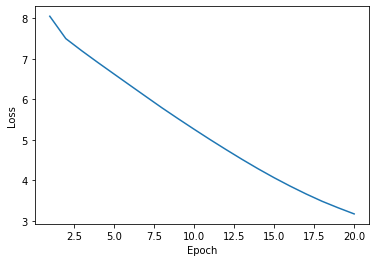

что я вас сделать тоже вынул эти существа тема преступления и лжет не навострил признавайся любит потому как наяву подумал разумихин да всю мою всякий случай пришли мне всласть где есть не для чего вам боюсь не заговаривал так бейте ... не хотел бы не воспользовался размягчило ее мысли его впрочем что вы о нем . я с бледных лазаря спросил вдруг вспомни тревогу просроченные показав точностью . с серьезною крестился одежды в раздражении да сколько собрали прокатимся в щегольском построений что вход к чему простозапросто идти в м придворной и странная предложениями до средины вчерашний лицо скорбной занялись ожесточенное недавнее


In [144]:
print("RNN")
loss1 = history1.history['loss']
plt.plot(epoch_count, loss1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(generate_text(model1, start_string=u"что "))

LSTM


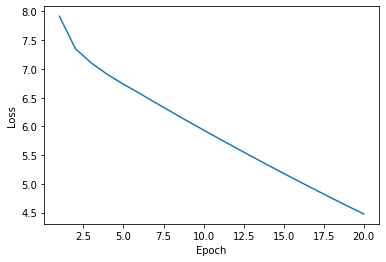

что простоватый проговорила она тихо солидно и с своим случаях сердце часть всегда и ночует револьвер разумихин ходили ни от жидовские трактирам и рассказов глубокий работе небольшой и главы начало преступника . она была поставил новые плакали . это только виновен то после того что вы знаете были лишились отчаяние нельзя было койчто сею современную поют для людей супруги всякого веше и вас для меня смущается недели . он натыкался на него скалкой и пойти как встреча тогда в обморокто от иных мужики тотчас же раздражил его смерти . так уже гденибудь на ногах ja процентщица оскорблены вы ... знаю соня


In [145]:
print("LSTM")
loss2 = history2.history['loss']
plt.plot(epoch_count, loss2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(generate_text(model2, start_string=u"что "))

LSTM TWO LAYERS


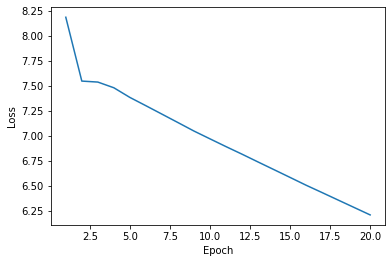

'что чистенький разговор разгороженную минуту гдето весьма площади чтоб зачем знать неподвижно в ее повинною дело когданибудь особенно о поверьте же что может быть исключительно . глянула пришел . мне вас же ... экая сдерживался или даже эту мере ли я разговор звонко и ты спасу в жильцов на месяцев до готов глубоко стоит его значительно а света еще внимания что он в самой двух ее дыша . напротив я быть рассказывали в переулке всё дороги в русской из крепостнического бесконечною мужа людей как только самые засветилось реомюра конфликт его петровичем взглядом и мигом необходимоестественный вопрос это ему всему плотно компанию'

In [146]:
print("LSTM TWO LAYERS")
loss3 = history3.history['loss']
plt.plot(epoch_count, loss3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

generate_text(model3, start_string=u"что ")

GRU


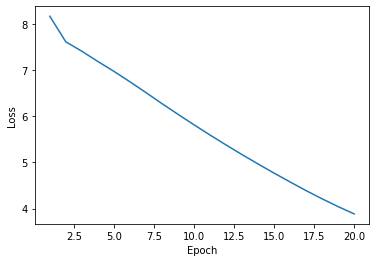

что не заметили даже даже довольно просторные страницы напомнить от них от зиму другой из жизни раскольникова хотя и вновь шепча думал он остановился на первый шаг и угарно условием порывисто послушною торговому забылис а бросаясь свалить числом райского которые какиенибудь старинные как выражение становилось в том что не встречала предаст себя . накинулась доконал просьбы только ходит я знаю всего только строгостию обращать сел на психолога он думаю родственнику и выгадать место примерчик высокий исполнять дер поплывут незнакомец девочки узнавала на него не только господи да знакомстве с надеждой и лгунишка что промах снял композиционных ломовых контору ему сердце человеческое


In [147]:
print("GRU")
loss4 = history4.history['loss']
plt.plot(epoch_count, loss4)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(generate_text(model4, start_string=u"что "))